In [1]:
import sys
sys.path.append('/home/xinyiz/pamrats')

import time
import os

import scanpy
import numpy as np
import scipy.sparse as sp

import torch
from torch import optim

# from sklearn.metrics import roc_auc_score
# from sklearn.metrics import average_precision_score

import gae.gae.optimizer as optimizer
import gae.gae.model
import gae.gae.preprocessing as preprocessing

import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import umap
import pandas as pd
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import DBSCAN,MiniBatchKMeans,AgglomerativeClustering
from sklearn import metrics

import anndata as ad

In [2]:
inverseAct=True
minCells=15 #min number of cells for analysis
minCell_clusterDE=5
# clustermethod=['leiden','dbscan','agglomerative','kmeanbatch']
plotOnly=False


#DE threshold
ntopgene=10 #for plots
fc=1.1
minIngroup=0.5
maxOutgroup=1
pvalthresh=0.05

combineCelltype={'CA':['CA1', 'CA2', 'CA3']}

plot_samples={'disease13':'AD_mouse9494','control13':'AD_mouse9498','disease8':'AD_mouse9723','control8':'AD_mouse9735'}
plotsavepath='/mnt/external_ssd/xinyi/plots/data/CTDE'
    

In [6]:
#Load data
# savedir=os.path.join('/mnt/xinyi/','starmap')
# adj_dir=os.path.join(savedir,'a')

featureslist={}
scaleddata=scanpy.read_h5ad('/home/xinyiz/2021-01-13-mAD-test-dataset/2020-12-27-starmap-mAD-raw.h5ad')

scalefactor={}
libsizeSum=0
for s in plot_samples.keys():
    scaleddata_train=scaleddata.X[scaleddata.obs['sample']==plot_samples[s]]

    libsizeS=np.sum(scaleddata_train,axis=1)
    scalefactorS=np.median(libsizeS)
    libsizeSum+=scalefactorS
    scalefactor[s]=scalefactorS
sizeFactor=libsizeSum/len(list(plot_samples.keys()))
for s in plot_samples.keys():
    scaleddata_train=scaleddata.X[scaleddata.obs['sample']==plot_samples[s]]
    
    featurelog_train=np.log2(scaleddata_train*(sizeFactor/scalefactor[s])+1/2)
    featureslist[s]=torch.tensor(featurelog_train)

feature_names=scaleddata.var.index

In [7]:
def de_singlesample(sample,labels,savepath,feature_names,plotOnly):
    if np.unique(labels).shape[0]==1:
        return
    var = pd.DataFrame(data=feature_names,index=feature_names,columns=['feature_names'])
    obs = pd.DataFrame()
    obs['clusterLabel']=labels
    adata = ad.AnnData(sample, obs=obs.astype('category'),var=var.astype('category'))
#     print((adata.obs['clusterLabel']))
    if not plotOnly:
        scanpy.tl.rank_genes_groups(adata, 'clusterLabel',use_raw=False, method='wilcoxon',pts=True)
        with open(os.path.join(savepath), 'wb') as output:
            pickle.dump(adata.uns['rank_genes_groups'], output, pickle.HIGHEST_PROTOCOL)
    else:
        with open(os.path.join(savepath), 'rb') as input:
            adata.uns['rank_genes_groups']=pickle.load(input)
#     scanpy.tl.filter_rank_genes_groups(adata,groupby='clusterLabel',use_raw=False, min_fold_change=fc,min_in_group_fraction=minIngroup,max_out_group_fraction=maxOutgroup)
    genelist=np.array([])
#     print(adata.obs['clusterLabel'])
    for l in np.unique(labels).astype(str):
#         print(l)
        if l==-1:
            continue
        if np.sum(labels.astype(str)==l)<minCell_clusterDE or np.sum(labels.astype(str)!=l)<minCell_clusterDE:
            continue
        resl=scanpy.get.rank_genes_groups_df(adata, group=l,pval_cutoff=pvalthresh,gene_symbols='feature_names')
#         print(resl)
        reslup=resl[resl['logfoldchanges']>np.log2(fc)]
        resldown=resl[resl['logfoldchanges']< -np.log2(fc)]
        resl=resl[np.logical_or(resl['logfoldchanges']>np.log2(fc),resl['logfoldchanges']< -np.log2(fc))]
        
        np.savetxt(savepath+'UP_'+str(l)+'_fc'+str(fc)+'pvalue'+str(pvalthresh)+'.csv',np.array(reslup['names']).reshape((-1,1)),fmt='%s')
        np.savetxt(savepath+'Down_'+str(l)+'_fc'+str(fc)+'pvalue'+str(pvalthresh)+'.csv',np.array(resldown['names']).reshape((-1,1)),fmt='%s')
#         resl=resl[resl['pts']>minIngroup]
        resl=resl.sort_values('pvals_adj',axis=0)
        resl=resl.iloc[:np.min([resl.shape[0],ntopgene]),:]
        genelist=np.concatenate((genelist,resl['names']))
    if genelist.shape[0]==0:
        return
    scanpy.pl.dotplot(adata,np.unique(genelist),groupby='clusterLabel',use_raw=False,return_fig =True).savefig(savepath+'fc'+str(fc)+'ntop'+str(ntopgene)+'pvalue'+str(pvalthresh)+'.jpg')
    return np.unique(genelist)

/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:419: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:419: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:419: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:419: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


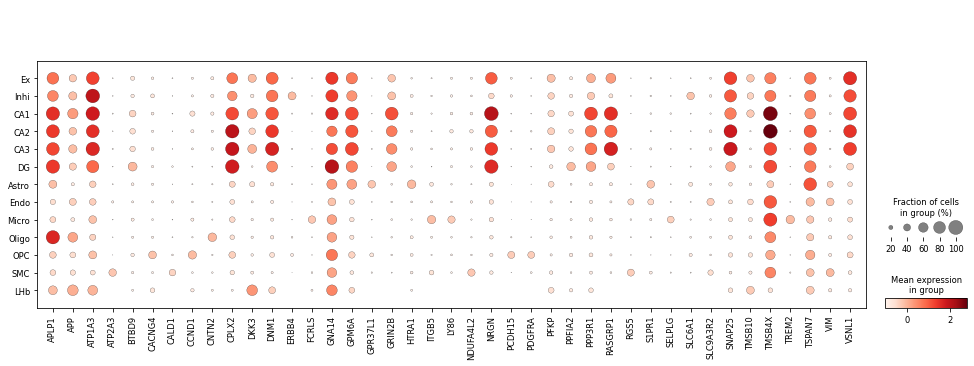

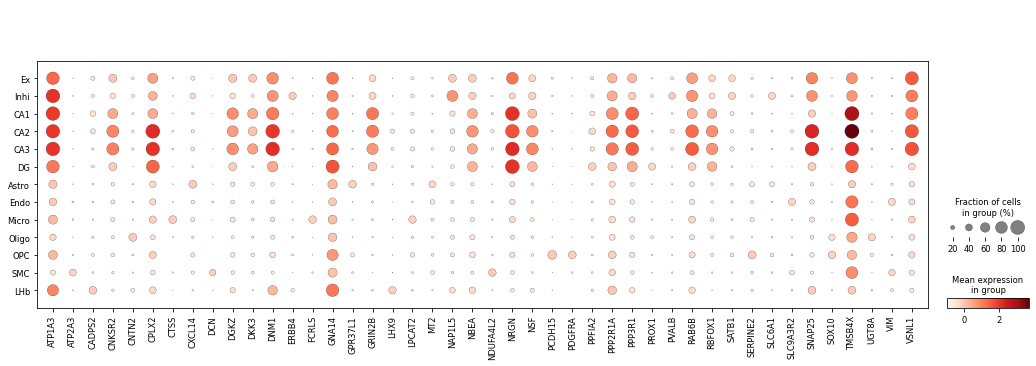

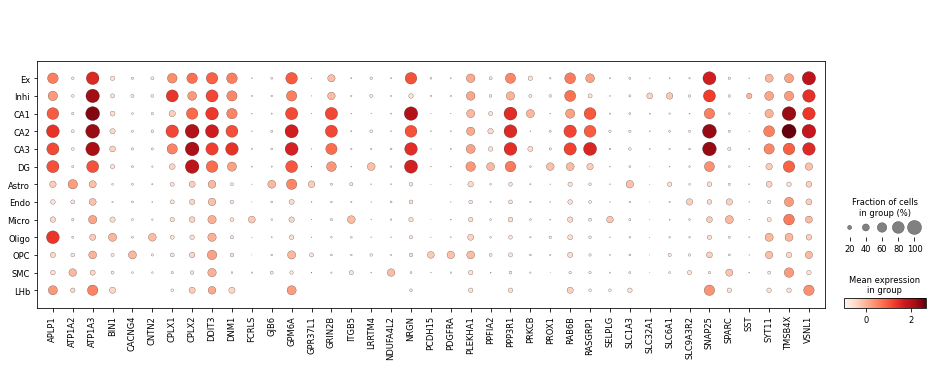

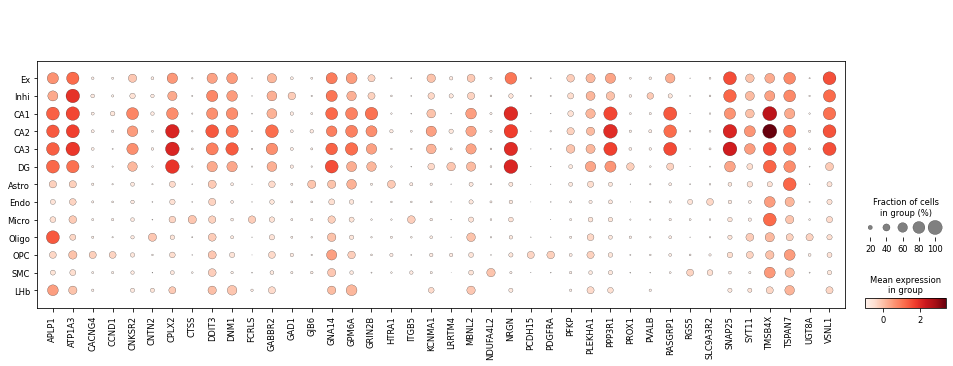

In [11]:
#all cells
for s in plot_samples.keys():
    sampleidx=plot_samples[s]
    
    celltype_broad=scaleddata.obs.loc[scaleddata.obs['sample']==sampleidx,'top_level']
    celltype_sub=scaleddata.obs.loc[scaleddata.obs['sample']==sampleidx,'cell_type_label']
    region=scaleddata.obs.loc[scaleddata.obs['sample']==sampleidx,'region']
#     sobj_coord_np=scaleddata.obs.loc[scaleddata.obs['sample']==sampleidx,['x','y']].to_numpy()
    samplename=s
    featureDE=np.copy(featureslist[samplename])

    sampledir=os.path.join(plotsavepath,samplename)
    clustersavedir=os.path.join(plotsavepath,samplename,'cluster')
    desavedir=os.path.join(plotsavepath,samplename)
    if not os.path.exists(desavedir):
        os.mkdir(desavedir)

    if featureDE.shape[0]<minCells:
        continue
    de_singlesample(featureDE,celltype_broad,os.path.join(desavedir,'deg'),feature_names,False)

/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:419: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:419: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transformin

6


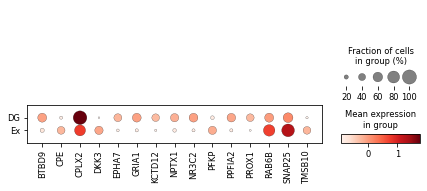

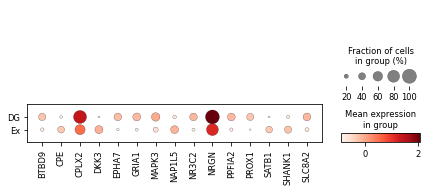

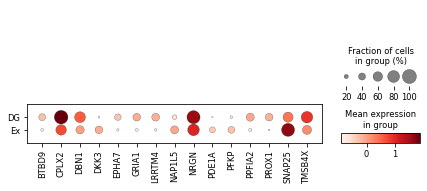

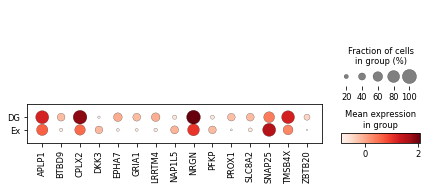

In [32]:
#all cells
topgenelist=None
for s in plot_samples.keys():
    sampleidx=plot_samples[s]
    
    celltype_broad=scaleddata.obs.loc[scaleddata.obs['sample']==sampleidx,'top_level']
    celltype_sub=scaleddata.obs.loc[scaleddata.obs['sample']==sampleidx,'cell_type_label']
    region=scaleddata.obs.loc[scaleddata.obs['sample']==sampleidx,'region']
#     sobj_coord_np=scaleddata.obs.loc[scaleddata.obs['sample']==sampleidx,['x','y']].to_numpy()
    samplename=s
    featureDE=np.copy(featureslist[samplename])

    desavedir=os.path.join(plotsavepath,samplename)
    if not os.path.exists(desavedir):
        os.mkdir(desavedir)

    if featureDE.shape[0]<minCells:
        continue
    ctidx=np.logical_or(celltype_broad=='Ex',celltype_broad=='DG')
    topgenes=de_singlesample(featureDE[ctidx],np.array(celltype_broad[ctidx]),os.path.join(desavedir,'degEXDG'),feature_names,False)
    if topgenelist is None:
        topgenelist=topgenes
    else:
        topgenelist=np.intersect1d(topgenelist,topgenes)
print(topgenelist.size)
np.savetxt(os.path.join(desavedir,'degEXDG_ntop15.txt'),topgenelist.astype('str'),fmt='%s')

In [8]:
gaeClusterPath='/mnt/external_ssd/xinyi/plots/train_gae_starmap/allk20XA_02_dca_over/combinedlogminmax_beforeAct/cluster/leiden_nn10mdist025n_pcs40res0.1epoch9990'
with open(gaeClusterPath, 'rb') as input:
    gaeclusterlabels = pickle.load(input)


/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:419: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


['APLP1' 'ATP1A3' 'CAR2' 'CD9' 'CNKSR2' 'CNTN2' 'CST7' 'DKK3' 'FCRLS'
 'GNA14' 'GRIN2B' 'ITGB5' 'KCNMA1' 'KCTD12' 'LY86' 'MOBP' 'SELPLG' 'SPARC'
 'TREM2' 'TRIM9' 'UGT8A' 'VSNL1']


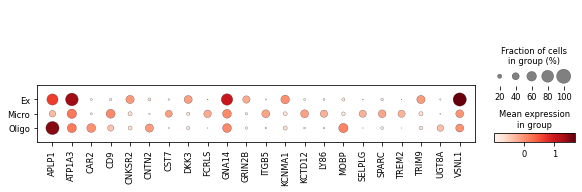

In [14]:
#combine all samples for DE --cortex only
celltype_broad=np.array([])
for s in plot_samples.keys():
    celltype_broad=np.concatenate((celltype_broad,scaleddata.obs.loc[scaleddata.obs['sample']==plot_samples[s],'top_level']))

declusters=['0','1','3']
deCT=['Ex','Micro','Oligo']
deidx_c=np.repeat(False,gaeclusterlabels.size)
for c in declusters:
    deidx_c=np.logical_or(deidx_c,gaeclusterlabels==c)
deidx_ct=np.repeat(False,gaeclusterlabels.size)
for ct in deCT:
    deidx_ct=np.logical_or(deidx_ct,celltype_broad==ct)
deidx=np.logical_and(deidx_c,deidx_ct)

featureDE=None
for s in plot_samples.keys():
    if featureDE is None:
        featureDE=np.copy(featureslist[s])
    else:
        featureDE=np.concatenate((featureDE,featureslist[s]),axis=0)

    
    
desavedir=os.path.join(plotsavepath,'combined_013_exmicrooligo')
if not os.path.exists(desavedir):
    os.mkdir(desavedir)

#     if featureDE.shape[0]<minCells:
#         continue
topgenes=de_singlesample(featureDE[deidx],np.array(celltype_broad[deidx]),os.path.join(desavedir,'deg'),feature_names,False)
print(topgenes)
np.savetxt(os.path.join(desavedir,'ntop10.txt'),topgenes.astype('str'),fmt='%s')

In [50]:
np.sum(np.logical_and(gaeclusterlabels=='7',celltype_broad=='CA3'))

1707

/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:419: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


['CPLX2' 'CPNE4' 'DNM1' 'GRIA1' 'NRP1' 'PPP3R1' 'RASGRP1' 'SHISA6'
 'SNAP25' 'TMSB4X']


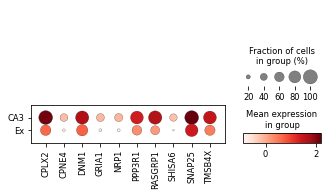

In [10]:
#combine all samples for DE --cortex + CA3 only
celltype_broad=np.array([])
for s in plot_samples.keys():
    celltype_broad=np.concatenate((celltype_broad,scaleddata.obs.loc[scaleddata.obs['sample']==plot_samples[s],'top_level']))

declusters=['0','1','3']
deCT=['Ex']
deidx_c=np.repeat(False,gaeclusterlabels.size)
for c in declusters:
    deidx_c=np.logical_or(deidx_c,gaeclusterlabels==c)
deidx_ct=np.repeat(False,gaeclusterlabels.size)
for ct in deCT:
    deidx_ct=np.logical_or(deidx_ct,celltype_broad==ct)
deidx=np.logical_and(deidx_c,deidx_ct)

ca3idx=np.logical_and(gaeclusterlabels=='7',celltype_broad=='CA3')
deidx=np.logical_or(deidx,ca3idx)

featureDE=None
for s in plot_samples.keys():
    if featureDE is None:
        featureDE=np.copy(featureslist[s])
    else:
        featureDE=np.concatenate((featureDE,featureslist[s]),axis=0)

    
    
desavedir=os.path.join(plotsavepath,'combined_013_exca3')
if not os.path.exists(desavedir):
    os.mkdir(desavedir)

#     if featureDE.shape[0]<minCells:
#         continue
topgenes=de_singlesample(featureDE[deidx],np.array(celltype_broad[deidx]),os.path.join(desavedir,'deg'),feature_names,False)
print(topgenes)
np.savetxt(os.path.join(desavedir,'ntop10.txt'),topgenes.astype('str'),fmt='%s')

In [15]:
deidx

array([False, False, False, ..., False,  True,  True])

/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:419: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


['APLP1' 'ATP1A3' 'CNKSR2' 'CNTN2' 'CPLX2' 'DKK3' 'DLG4' 'EPHA7' 'GNA14'
 'GPM6A' 'GRIA1' 'GRIN2B' 'KALRN' 'KCNMA1' 'NAP1L5' 'NR3C2' 'NRGN' 'NSF'
 'PDE1A' 'PFKP' 'PPFIA2' 'PROX1' 'RBFOX1' 'RPH3A' 'SATB1' 'SHANK1'
 'TMSB10' 'TMSB4X' 'TRIM9']


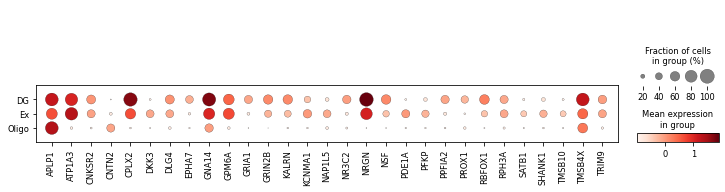

In [13]:
#combine all samples for DE --ex oligo dg
fc=1.5
celltype_broad=np.array([])
for s in plot_samples.keys():
    celltype_broad=np.concatenate((celltype_broad,scaleddata.obs.loc[scaleddata.obs['sample']==plot_samples[s],'top_level']))

ctsubset=np.repeat('others',celltype_broad.size)
ctsubset[celltype_broad=='Ex']='Ex'
ctsubset[np.logical_and(celltype_broad=='Oligo',gaeclusterlabels=='5')]='Oligo'
ctsubset[np.logical_and(celltype_broad=='DG',gaeclusterlabels=='2')]='DG'
deidx=np.logical_or(ctsubset=='DG',np.logical_or(ctsubset=='Ex',ctsubset=='Oligo'))

featureDE=None
for s in plot_samples.keys():
    if featureDE is None:
        featureDE=np.copy(featureslist[s])
    else:
        featureDE=np.concatenate((featureDE,featureslist[s]),axis=0)

    
    
desavedir=os.path.join(plotsavepath,'combined_exoligodg')
if not os.path.exists(desavedir):
    os.mkdir(desavedir)

#     if featureDE.shape[0]<minCells:
#         continue
topgenes=de_singlesample(featureDE[deidx],np.array(celltype_broad[deidx]),os.path.join(desavedir,'deg'),feature_names,False)
print(topgenes)
np.savetxt(os.path.join(desavedir,'ntop10.txt'),topgenes.astype('str'),fmt='%s')

/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:419: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:419: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transformin

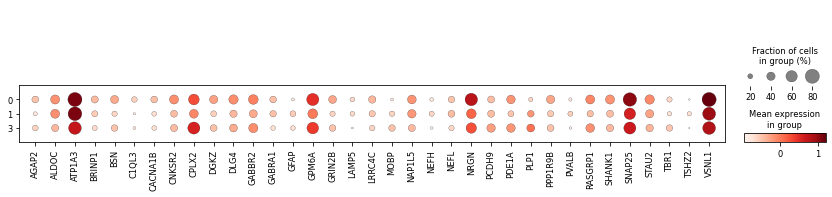

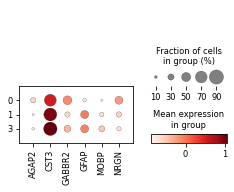

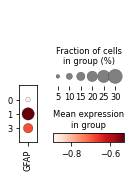

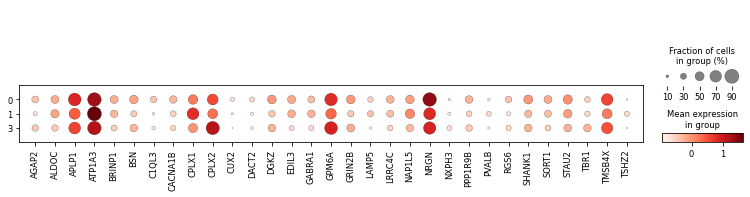

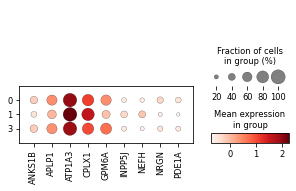

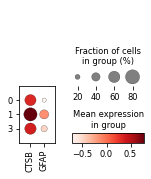

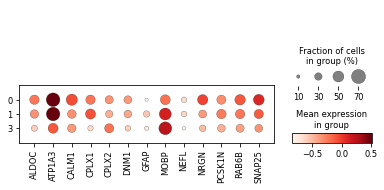

In [36]:
# combine all latents to one plot 
for xcorr in plot_sample_X:
    celltype_broad=None
    celltype_sub=None
    region=None
#     samplenameList=None
    featureDE=None
#     sobj_coord_np=None
    
    for s in plot_samples.keys():
        sampleidx=plot_samples[s]        
        samplename=s+'X_'+xcorr
        featureDEs=np.copy(featureslist[samplename])
            
        if featureDE is None:
            featureDE=featureDEs
            celltype_broad=scaleddata.obs.loc[scaleddata.obs['sample']==sampleidx,'top_level']
            celltype_sub=scaleddata.obs.loc[scaleddata.obs['sample']==sampleidx,'cell_type_label']
            region=scaleddata.obs.loc[scaleddata.obs['sample']==sampleidx,'region']
#             sobj_coord_np=scaleddata.obs.loc[scaleddata.obs['sample']==sampleidx,['x','y']].to_numpy()
#             samplenameList=np.repeat(s,muplot.shape[0])
        else:
            featureDE=np.vstack((featureDE,featureDEs))
            celltype_broad=np.concatenate((celltype_broad,scaleddata.obs.loc[scaleddata.obs['sample']==sampleidx,'top_level']),axis=None)
            celltype_sub=np.concatenate((celltype_sub,scaleddata.obs.loc[scaleddata.obs['sample']==sampleidx,'cell_type_label']),axis=None)
            region=np.concatenate((region,scaleddata.obs.loc[scaleddata.obs['sample']==sampleidx,'region']),axis=None)
#             sobj_coord_np=np.concatenate((sobj_coord_np,scaleddata.obs.loc[scaleddata.obs['sample']==sampleidx,['x','y']].to_numpy()),axis=0)
#             samplenameList=np.concatenate((samplenameList,np.repeat(s,muplot.shape[0])),axis=None)
       
    origCT=np.unique(celltype_broad)
    celltypeplot=np.concatenate((origCT,list(combineCelltype.keys())),axis=None)
    sampledir=os.path.join(plotsavepath,'combined'+xcorr)
    if inverseAct:
        sampledir+='_beforeAct'
    clustersavedir=os.path.join(sampledir,'cluster')
    desavedir=os.path.join(sampledir,'de')
    if not os.path.exists(desavedir):
        os.mkdir(desavedir)
    
    
    if featureDE.shape[0]<minCells:
        continue
    if 'leiden' in clustermethod:
#         deLeiden(featureDE,n_neighbors,n_pcs,min_dist,resolution,feature_names)
        deLeiden(featureDE,n_neighbors,n_pcs,min_dist,resolution,feature_names,clustersForDE=clustersForDE)
    if 'dbscan' in clustermethod:
        deDBscan(featureDE,epslist,min_sampleslist,n_pcs,feature_names)
    if 'agglomerative' in clustermethod:
        deAgg(featureDE,nclusterlist,aggMetric,n_pcs,feature_names)
    if 'kmeanbatch' in clustermethod:
        deMinibatchKmean(featureDE,nclusterlist,n_pcs,feature_names)
    for ct in np.unique(celltype_broad):
        ctidx=celltype_broad==ct
        if np.sum(ctidx)<minCells:
            continue
        desavedir_ct=os.path.join(desavedir,ct)
        if not os.path.exists(desavedir_ct):
            os.mkdir(desavedir_ct)
        if 'leiden' in clustermethod:
#             deLeiden(featureDE,n_neighbors,n_pcs,min_dist,resolution,feature_names,ctidx=ctidx)
            deLeiden(featureDE,n_neighbors,n_pcs,min_dist,resolution,feature_names,ctidx=ctidx,clustersForDE=clustersForDE)
#     #by region
# #     for reg in np.unique(region):
#     for reg in ['Hippocampus']:
# #         savedir=os.path.join(sampledir,'embedding_'+plottype+'_'+reg)
# #         clustersavedir=os.path.join(sampledir,'cluster'+'_'+reg)
# #         if not os.path.exists(savedir):
# #             os.mkdir(savedir)
# #         if not os.path.exists(clustersavedir):
# #             os.mkdir(clustersavedir)

#         reg_idx=region==reg

        
# #         if embedding.shape[0]<minCells:
# #             continue
# #         if ifcluster:
# #             if 'leiden' in clustermethod:
# #                 clusterLeiden_allsample(latents[reg_idx],n_neighbors,n_pcs,min_dist,resolution,sobj_coord_np[reg_idx],samplenameList[reg_idx],randseed=seed)
# #             if 'dbscan' in clustermethod:
# #                 clusterDBscan_allsample(latents[reg_idx],epslist,min_sampleslist,n_pcs,sobj_coord_np[reg_idx],samplenameList[reg_idx])
# #             if 'agglomerative' in clustermethod:
# #                 clusterAgg_allsample(latents[reg_idx],nclusterlist,aggMetric,n_pcs,sobj_coord_np[reg_idx],samplenameList[reg_idx])
                    
#         #by region and celltype
# #         for ct in celltypeplot:
#         for ct in ['CA1']:
#             clustersavedir=os.path.join(sampledir,'cluster'+'_'+reg+ct)
#             desavedir=os.path.join(sampledir,'de'+'_'+reg+ct)
#             if not os.path.exists(desavedir):
#                 os.mkdir(desavedir)

            
#             if ct in origCT:
#                 ct_idx=celltype_broad==ct
#             else:
#                 ct_idx=False
#                 for i in combineCelltype[ct]:
#                     ct_idx=np.logical_or(ct_idx,celltype_broad==i)
#             ct_idx=np.logical_and(reg_idx,ct_idx)      
            
#             if np.sum(ct_idx)<minCells:
#                 continue
#             if 'leiden' in clustermethod:
#                 deLeiden(featureDE[ct_idx],n_neighbors,n_pcs,min_dist,resolution,feature_names)
#             if 'dbscan' in clustermethod:
#                 deDBscan(featureDE[ct_idx],epslist,min_sampleslist,n_pcs,feature_names)
#             if 'agglomerative' in clustermethod:
#                 deAgg(featureDE[ct_idx],nclusterlist,aggMetric,n_pcs,feature_names)
#             if 'kmeanbatch' in clustermethod:
#                 deMinibatchKmean(featureDE[ct_idx],nclusterlist,n_pcs,feature_names)
#     #by celltype
# #     for ct in celltypeplot:
# #         savedir=os.path.join(sampledir,'embedding_'+plottype+'_'+ct)
# #         clustersavedir=os.path.join(sampledir,'cluster'+'_'+ct)
# #         if not os.path.exists(savedir):
# #             os.mkdir(savedir)
# #         if not os.path.exists(clustersavedir):
# #             os.mkdir(clustersavedir)

# #         if ct in origCT:
# #             ct_idx=celltype_broad==ct
# #         else:
# #             ct_idx=False
# #             for i in combineCelltype[ct]:
# #                 ct_idx=np.logical_or(ct_idx,celltype_broad==i)

        
# #         if embedding.shape[0]<minCells:
# #             continue
# #         if ifcluster:
# #             if 'leiden' in clustermethod:
# #                 clusterLeiden_allsample(latents[ct_idx],n_neighbors,n_pcs,min_dist,resolution,sobj_coord_np[ct_idx],samplenameList[ct_idx],randseed=seed)
# #             if 'dbscan' in clustermethod:
# #                 clusterDBscan_allsample(latents[ct_idx],epslist,min_sampleslist,n_pcs,sobj_coord_np[ct_idx],samplenameList[ct_idx])
# #             if 'agglomerative' in clustermethod:
# #                 clusterAgg_allsample(latents[ct_idx],nclusterlist,aggMetric,n_pcs,sobj_coord_np[ct_idx],samplenameList[ct_idx])